In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import albumentations as A

In [5]:
# Kaggle dataset paths
image_dir = "/kaggle/input/kvasir-seg-dataset/Kvasir-SEG/images"
mask_dir = "/kaggle/input/kvasir-seg-dataset/Kvasir-SEG/masks"

print("Images:", len(os.listdir(image_dir)))
print("Masks:", len(os.listdir(mask_dir)))

Images: 1000
Masks: 1000


In [6]:
import os
import shutil

# Original (read-only) dataset paths
src_image_dir = "/kaggle/input/kvasir-seg-dataset/Kvasir-SEG/images"
src_mask_dir = "/kaggle/input/kvasir-seg-dataset/Kvasir-SEG/masks"

# Copy dataset to working directory (writable)
dst_base = "/kaggle/working/kvasir_renamed"
dst_image_dir = os.path.join(dst_base, "images")
dst_mask_dir = os.path.join(dst_base, "masks")

os.makedirs(dst_image_dir, exist_ok=True)
os.makedirs(dst_mask_dir, exist_ok=True)

# Copy files if not already copied
if not os.listdir(dst_image_dir):
    for f in os.listdir(src_image_dir):
        shutil.copy(os.path.join(src_image_dir, f), dst_image_dir)
    for f in os.listdir(src_mask_dir):
        shutil.copy(os.path.join(src_mask_dir, f), dst_mask_dir)
    print("✅ Dataset copied to working directory")

def rename_dataset(image_dir, mask_dir):
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])
    mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('.jpg')])
    
    for i, (img, msk) in enumerate(zip(image_files, mask_files), start=1):
        new_img_name = f"coloscopy_{i:03d}.jpg"
        new_mask_name = f"mask_{i:03d}.jpg"
        
        os.rename(os.path.join(image_dir, img), os.path.join(image_dir, new_img_name))
        os.rename(os.path.join(mask_dir, msk), os.path.join(mask_dir, new_mask_name))
    
    print(f"✅ Renamed {len(image_files)} images and masks")

# Call once
rename_dataset(dst_image_dir, dst_mask_dir)

# Verify
print("✅ Renamed Images (first 10):")
for f in sorted(os.listdir(dst_image_dir))[:10]:
    print(f)

print("\n✅ Renamed Masks (first 10):")
for f in sorted(os.listdir(dst_mask_dir))[:10]:
    print(f)


✅ Dataset copied to working directory
✅ Renamed 1000 images and masks
✅ Renamed Images (first 10):
coloscopy_001.jpg
coloscopy_002.jpg
coloscopy_003.jpg
coloscopy_004.jpg
coloscopy_005.jpg
coloscopy_006.jpg
coloscopy_007.jpg
coloscopy_008.jpg
coloscopy_009.jpg
coloscopy_010.jpg

✅ Renamed Masks (first 10):
mask_001.jpg
mask_002.jpg
mask_003.jpg
mask_004.jpg
mask_005.jpg
mask_006.jpg
mask_007.jpg
mask_008.jpg
mask_009.jpg
mask_010.jpg


In [7]:

# ======  DATA LOADING ======
def load_images_and_masks(image_dir, mask_dir, size=(256, 256)):
    """Fixed data loading with proper error handling"""
    images, masks = [], []
    
    # Get matching files properly
    valid_exts = ('.jpg', '.png', '.jpeg')
    image_files = sorted([f for f in os.listdir(image_dir) if f.lower().endswith(valid_exts)])
    mask_files  = sorted([f for f in os.listdir(mask_dir)  if f.lower().endswith(valid_exts)])

    # image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])
    # mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('.jpg')])
    
    print(f"Found {len(image_files)} images and {len(mask_files)} masks")
    
    for i, (image_file, mask_file) in enumerate(zip(image_files, mask_files)):
        try:
            # Load and preprocess image
            img = cv2.imread(os.path.join(image_dir, image_file))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            img = cv2.resize(img, size)
            img = img.astype(np.float32) / 255.0  # Normalize to [0,1]
            
            # Load and preprocess mask
            mask = cv2.imread(os.path.join(mask_dir, mask_file), cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, size)
            
            # CRITICAL FIX: Proper mask binarization
            mask = (mask > 127).astype(np.float32)  # Binary: 0 or 1
            mask = np.expand_dims(mask, axis=-1)  # Add channel dimension
            
            # Debug: Check mask statistics
            if i < 5:  # Print stats for first 5 images
                print(f"Image {i}: mask min={mask.min():.3f}, max={mask.max():.3f}, mean={mask.mean():.3f}")
            
            images.append(img)
            masks.append(mask)
            
        except Exception as e:
            print(f"Error loading {image_file}: {e}")
            continue
    
    return np.array(images), np.array(masks)

In [8]:
# Load the dataset
print("Loading dataset...")
X, Y = load_images_and_masks(image_dir, mask_dir)
print(f"Dataset loaded: {X.shape} images, {Y.shape} masks")

Loading dataset...
Found 1000 images and 1000 masks
Image 0: mask min=0.000, max=1.000, mean=0.283
Image 1: mask min=0.000, max=1.000, mean=0.271
Image 2: mask min=0.000, max=1.000, mean=0.319
Image 3: mask min=0.000, max=1.000, mean=0.109
Image 4: mask min=0.000, max=1.000, mean=0.073
Dataset loaded: (1000, 256, 256, 3) images, (1000, 256, 256, 1) masks


In [9]:
# ====== IMPROVED LOSS FUNCTIONS ======
def dice_loss(y_true, y_pred, smooth=1e-7):
    """Dice loss for better handling of small objects"""
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice

def focal_loss(y_true, y_pred, alpha=0.75, gamma=2.0):
    """Focal loss for class imbalance"""
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
    
     # Calculate focal loss
    alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)
    p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
    focal_loss = -alpha_t * K.pow((1 - p_t), gamma) * K.log(p_t)
    
    return K.mean(focal_loss)

def combined_loss(y_true, y_pred):
    """Combination of dice loss and focal loss"""
    dice = dice_loss(y_true, y_pred)
    focal = focal_loss(y_true, y_pred)
    return dice + focal

In [10]:
# ====== IMPROVED U-NET ARCHITECTURE ======
def build_improved_unet(input_shape=(256, 256, 3), dropout_rate=0.3):
    """Improved U-Net with batch normalization and dropout"""
    inputs = Input(input_shape)
    
    # Encoder Path
    def conv_block(x, filters, dropout_rate=0.3):
        x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout_rate)(x)
        x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        return x
    
    # Contracting Path
    c1 = conv_block(inputs, 64, dropout_rate)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = conv_block(p1, 128, dropout_rate)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = conv_block(p2, 256, dropout_rate)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = conv_block(p3, 512, dropout_rate)
    p4 = MaxPooling2D((2, 2))(c4)
    
    # Bottleneck
    b1 = conv_block(p4, 1024, dropout_rate)
    
    # Expansive Path
    u1 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(b1)
    u1 = concatenate([u1, c4])
    c5 = conv_block(u1, 512, dropout_rate)
    
    u2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
    u2 = concatenate([u2, c3])
    c6 = conv_block(u2, 256, dropout_rate)
    
    u3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
    u3 = concatenate([u3, c2])
    c7 = conv_block(u3, 128, dropout_rate)
    
    u4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
    u4 = concatenate([u4, c1])
    c8 = conv_block(u4, 64, dropout_rate)
    
    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c8)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model


In [11]:
# ====== TRAINING SETUP ======
def setup_training():
    """Setup training with proper callbacks and metrics"""
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
    
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        ),
        ModelCheckpoint(
            'best_unet_model_v1.h5',
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        )
    ]
    
    return callbacks

In [12]:
# ====== IMPROVED METRICS ======
def iou_metric(y_true, y_pred, threshold=0.5):
    """IoU metric for Keras"""
    y_pred = tf.cast(y_pred > threshold, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1,2,3])
    union = tf.reduce_sum(y_true, axis=[1,2,3]) + tf.reduce_sum(y_pred, axis=[1,2,3]) - intersection
    iou = (intersection + 1e-7) / (union + 1e-7)
    return tf.reduce_mean(iou)

def dice_metric(y_true, y_pred, threshold=0.5):
    """Dice metric for Keras"""
    y_pred = tf.cast(y_pred > threshold, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1,2,3])
    dice = (2. * intersection + 1e-7) / (tf.reduce_sum(y_true, axis=[1,2,3]) + tf.reduce_sum(y_pred, axis=[1,2,3]) + 1e-7)
    return tf.reduce_mean(dice)


In [13]:
# ====== DATA SPLITTING ======
# Split data
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# Check class distribution
print("\nClass distribution analysis:")
print(f"Training - Background: {np.sum(Y_train == 0)}, Polyp: {np.sum(Y_train == 1)}")
print(f"Validation - Background: {np.sum(Y_val == 0)}, Polyp: {np.sum(Y_val == 1)}")
print(f"Training polyp ratio: {np.sum(Y_train == 1) / Y_train.size:.4f}")
print(f"Validation polyp ratio: {np.sum(Y_val == 1) / Y_val.size:.4f}")



Class distribution analysis:
Training - Background: 44440970, Polyp: 7987830
Validation - Background: 11006056, Polyp: 2101144
Training polyp ratio: 0.1524
Validation polyp ratio: 0.1603


In [14]:
# ====== AUGMENTATION (OPTIONAL) ======
# augmentation = A.Compose([
#     A.HorizontalFlip(p=0.5),
#     A.VerticalFlip(p=0.5),
#     A.Rotate(limit=30, p=0.5),
#     A.RandomBrightnessContrast(p=0.5),
#     A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
# ])

# Apply augmentation
# print("\nApplying augmentation...")
# augmented_images = []
# augmented_masks = []

# for img, mask in zip(X_train, Y_train):
#     # Convert to uint8 for albumentations
#     img_uint8 = (img * 255).astype(np.uint8)
#     mask_uint8 = (mask[:,:,0] * 255).astype(np.uint8)
    
#     augmented = augmentation(image=img_uint8, mask=mask_uint8)
    
#     # Convert back to float32
#     aug_img = augmented['image'].astype(np.float32) / 255.0
#     aug_mask = augmented['mask'].astype(np.float32) / 255.0
#     aug_mask = np.expand_dims(aug_mask, axis=-1)
    
#     augmented_images.append(aug_img)
#     augmented_masks.append(aug_mask)

# X_train_aug = np.array(augmented_images)
# Y_train_aug = np.array(augmented_masks)

# # Combine original and augmented data
# X_train_final = np.concatenate([X_train, X_train_aug], axis=0)
# Y_train_final = np.concatenate([Y_train, Y_train_aug], axis=0)

# # Shuffle final training set
# X_train_final, Y_train_final = shuffle(X_train_final, Y_train_final, random_state=42)

# print(f"Final training set: {X_train_final.shape}")
# print(f"Final training masks: {Y_train_final.shape}")


# ====== AUGMENTATION (OPTIONAL) ======
augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5),
    
])

# Apply augmentation
print("\nApplying augmentation...")
augmented_images = []
augmented_masks = []

for img, mask in zip(X_train, Y_train):
    img_uint8 = (img * 255).astype(np.uint8)
    mask_uint8 = (mask[:,:,0] * 255).astype(np.uint8)

    augmented = augmentation(image=img_uint8, mask=mask_uint8)

    # Convert back to float32
    aug_img = augmented['image'].astype(np.float32) / 255.0
    aug_mask = (augmented['mask'] > 127).astype(np.float32)   # ✅ critical fix
    aug_mask = np.expand_dims(aug_mask, axis=-1)

    augmented_images.append(aug_img)
    augmented_masks.append(aug_mask)

X_train_aug = np.array(augmented_images)
Y_train_aug = np.array(augmented_masks)

# Combine original and augmented data
X_train_final = np.concatenate([X_train, X_train_aug], axis=0)
Y_train_final = np.concatenate([Y_train, Y_train_aug], axis=0)

# Shuffle final training set
X_train_final, Y_train_final = shuffle(X_train_final, Y_train_final, random_state=42)

print(f"Final training set: {X_train_final.shape}")
print(f"Final training masks: {Y_train_final.shape}")



Applying augmentation...
Final training set: (1600, 256, 256, 3)
Final training masks: (1600, 256, 256, 1)


In [15]:
# ====== BUILD AND COMPILE MODEL ======
print("\nBuilding model...")
model = build_improved_unet()

# Compile with improved loss and metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=combined_loss,
    metrics=['accuracy', iou_metric, dice_metric]
)

model.summary()



Building model...


I0000 00:00:1756287336.540661      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ dropout_1[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ dropout_2[0][0] 

 Total params: 31,055,297 (118.47 MB)

 Trainable params: 31,043,521 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [16]:
# ====== TRAINING ======
print("\nStarting training...")
callbacks = setup_training()

history = model.fit(
    X_train_final, Y_train_final,
    validation_data=(X_val, Y_val),
    batch_size=8,
    epochs=50,
    callbacks=callbacks,
    verbose=1
)


Starting training...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(8, 256, 256, 3))
  warnings.warn(msg)
I0000 00:00:1756287364.261071     118 service.cc:148] XLA service 0x79d89c0051c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756287364.262036     118 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1756287366.330485     118 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1756287399.836276     118 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.6103 - dice_metric: 0.3620 - iou_metric: 0.2439 - loss: 0.8082
Epoch 1: val_loss improved from inf to 1.03668, saving model to best_unet_model_v1.h5
200/200 ━━━━━━━━━━━━━━━━━━━━ 114s 286ms/step - accuracy: 0.6106 - dice_metric: 0.3623 - iou_metric: 0.2441 - loss: 0.8080 - val_accuracy: 0.8390 - val_dice_metric: 1.6299e-04 - val_iou_metric: 8.1821e-05 - val_loss: 1.0367 - learning_rate: 1.0000e-04
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.7982 - dice_metric: 0.5144 - iou_metric: 0.3824 - loss: 0.6796
Epoch 2: val_loss did not improve from 1.03668
200/200 ━━━━━━━━━━━━━━━━━━━━ 47s 234ms/step - accuracy: 0.7983 - dice_metric: 0.5145 - iou_metric: 0.3825 - loss: 0.6795 - val_accuracy: 0.8405 - val_dice_metric: 0.0130 - val_iou_metric: 0.0075 - val_loss: 1.3069 - learning_rate: 1.0000e-04
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.8746 - dice_metric: 0.6248 - iou_metric: 0.4944 - loss:

In [17]:
# ====== EVALUATION ======
print("\nEvaluating model...")

def evaluate_model(model, X_val, Y_val):
    """Evaluate model performance"""
    val_iou, val_dice, val_acc = [], [], []
    
    for i in range(len(X_val)):
        image = X_val[i]
        true_mask = Y_val[i]
        
        # Predict
        pred_mask = model.predict(np.expand_dims(image, axis=0), verbose=0)[0]
        
        # Calculate metrics
        pred_binary = (pred_mask > 0.5).astype(np.float32)
        
        # IoU
        intersection = np.sum(true_mask * pred_binary)
        union = np.sum(true_mask) + np.sum(pred_binary) - intersection
        iou = intersection / (union + 1e-7) if union > 0 else 1.0
        
        # Dice
        dice = (2. * intersection) / (np.sum(true_mask) + np.sum(pred_binary) + 1e-7)
        
        # Accuracy
        acc = np.mean(true_mask == pred_binary)
        
        val_iou.append(iou)
        val_dice.append(dice)
        val_acc.append(acc)
    
    return np.mean(val_iou), np.mean(val_dice), np.mean(val_acc)

mean_iou, mean_dice, mean_acc = evaluate_model(model, X_val, Y_val)

print(f"📌 Mean IoU:  {mean_iou:.4f}")
print(f"📌 Mean Dice: {mean_dice:.4f}")
print(f"📌 Accuracy:  {mean_acc:.4f}")



Evaluating model...


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 256, 256, 3))
  warnings.warn(msg)


📌 Mean IoU:  0.6964
📌 Mean Dice: 0.7941
📌 Accuracy:  0.9387



Visualizing predictions...


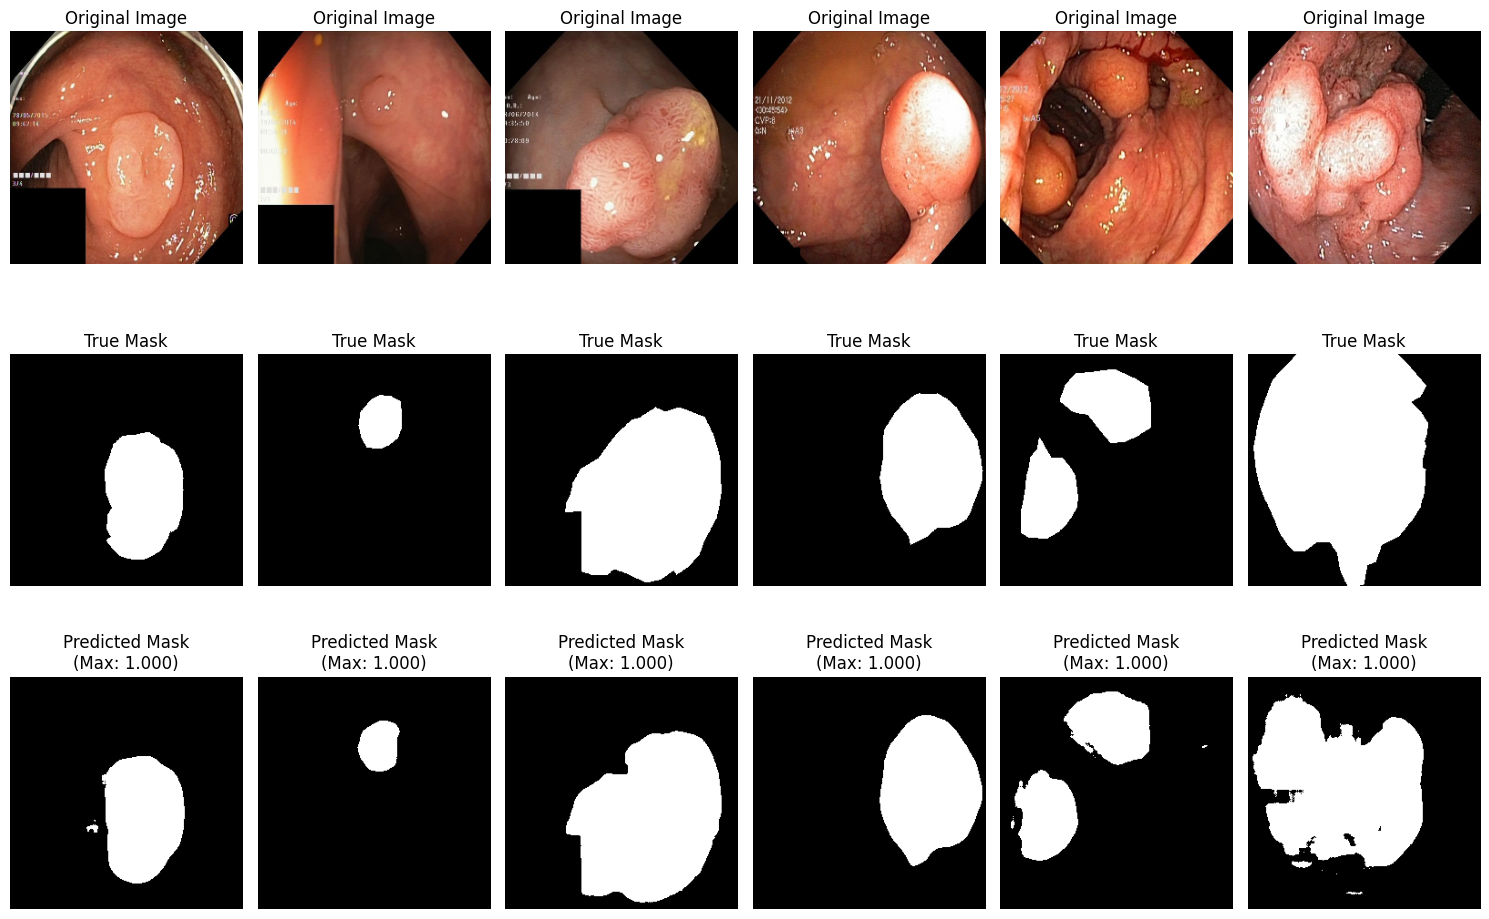

In [18]:
# ====== VISUALIZATION ======
def visualize_predictions(model, X_val, Y_val, num_samples=6):
    """Visualize predictions"""
    plt.figure(figsize=(15, 10))
    
    for i in range(num_samples):
        image = X_val[i]
        true_mask = Y_val[i]
        
        # Predict
        pred_mask = model.predict(np.expand_dims(image, axis=0), verbose=0)[0]
        pred_binary = (pred_mask > 0.5).astype(np.float32)
        
        # Plot
        plt.subplot(3, num_samples, i + 1)
        plt.imshow(image)
        plt.title("Original Image")
        plt.axis('off')
        
        plt.subplot(3, num_samples, i + num_samples + 1)
        plt.imshow(true_mask[:,:,0], cmap='gray')
        plt.title("True Mask")
        plt.axis('off')
        
        plt.subplot(3, num_samples, i + 2*num_samples + 1)
        plt.imshow(pred_binary[:,:,0], cmap='gray')
        plt.title(f"Predicted Mask\n(Max: {pred_mask.max():.3f})")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize results
print("\nVisualizing predictions...")
visualize_predictions(model, X_val, Y_val)


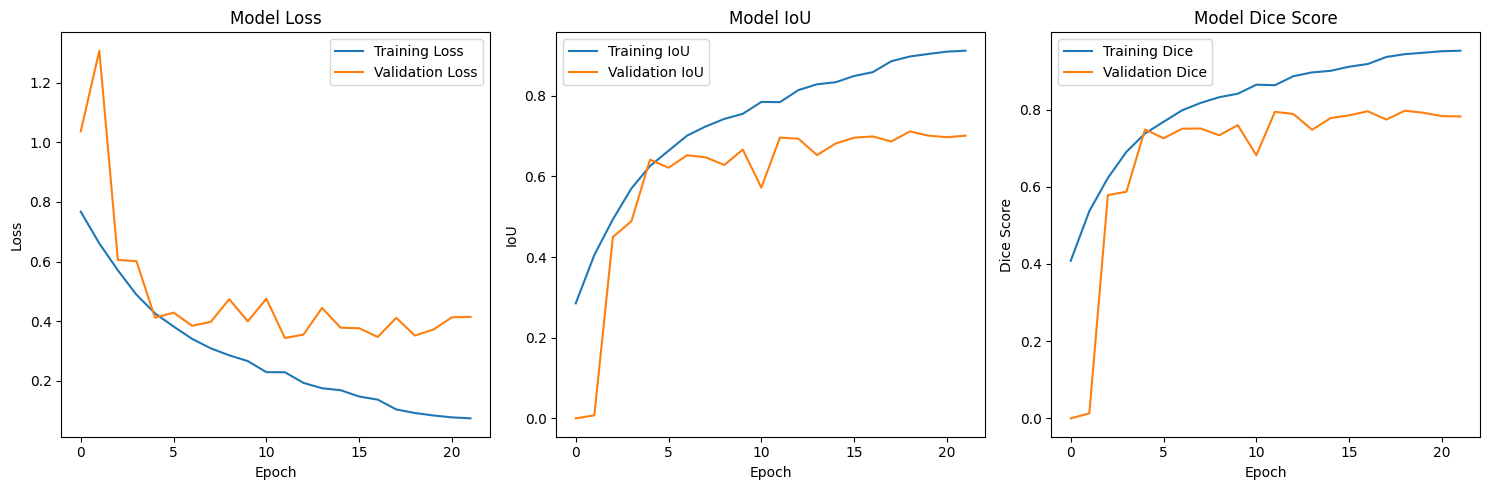

In [19]:
# ====== PLOT TRAINING HISTORY ======
def plot_training_history(history):
    """Plot training history"""
    plt.figure(figsize=(15, 5))
    
    # Loss
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # IoU
    plt.subplot(1, 3, 2)
    plt.plot(history.history['iou_metric'], label='Training IoU')
    plt.plot(history.history['val_iou_metric'], label='Validation IoU')
    plt.title('Model IoU')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()
    
    # Dice
    plt.subplot(1, 3, 3)
    plt.plot(history.history['dice_metric'], label='Training Dice')
    plt.plot(history.history['val_dice_metric'], label='Validation Dice')
    plt.title('Model Dice Score')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Score')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [22]:
# # Save the model
model.save('/kaggle/working/unet_polyp_segmentation_model_v1.h5')
print("\nModel saved as 'improved_unet_polyp_segmentation.h5'")


Model saved as 'improved_unet_polyp_segmentation.h5'


In [1]:
import tensorflow as tf
print(tf.__version__)


2025-08-27 14:16:36.367140: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756304196.543139      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756304196.594825      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.18.0
